# Showcase

In [1]:
library(here)
source(here("setup.R"))
options(encoding = "UTF-8")
Sys.setlocale("LC_ALL", "C")
library(reticulate)

expit <- function(x) {
    1 / (1 + exp(-x))
}
logit <- function(x) {
    log(x / (1 - x))
}
theta_to_params <- function(theta) {
    c(
        "alpha" = expit(theta[1]),
        "s2_r" = exp(theta[2]),
        "s2_spatial" = exp(theta[3]),
        "q" = expit(theta[4]),
        "C" = exp(theta[5]) + 1,
        "r" = exp(theta[6])
    )
}


here() starts at /Users/stefan/workspace/work/phd/thesis



[1] "C/C/C/C/C/de_DE"

In [2]:
full_truth_county <- read_csv(here("data/processed/RKI_county_weekly.csv")) 

full_truth <- full_truth_county %>%
    group_by(date) %>%
    summarize(cases = sum(cases, na.rm = TRUE))

ags_county_dict <- read_csv(here("data/processed/ags_county_dict.csv")) %>%
    mutate(c = 1:n())

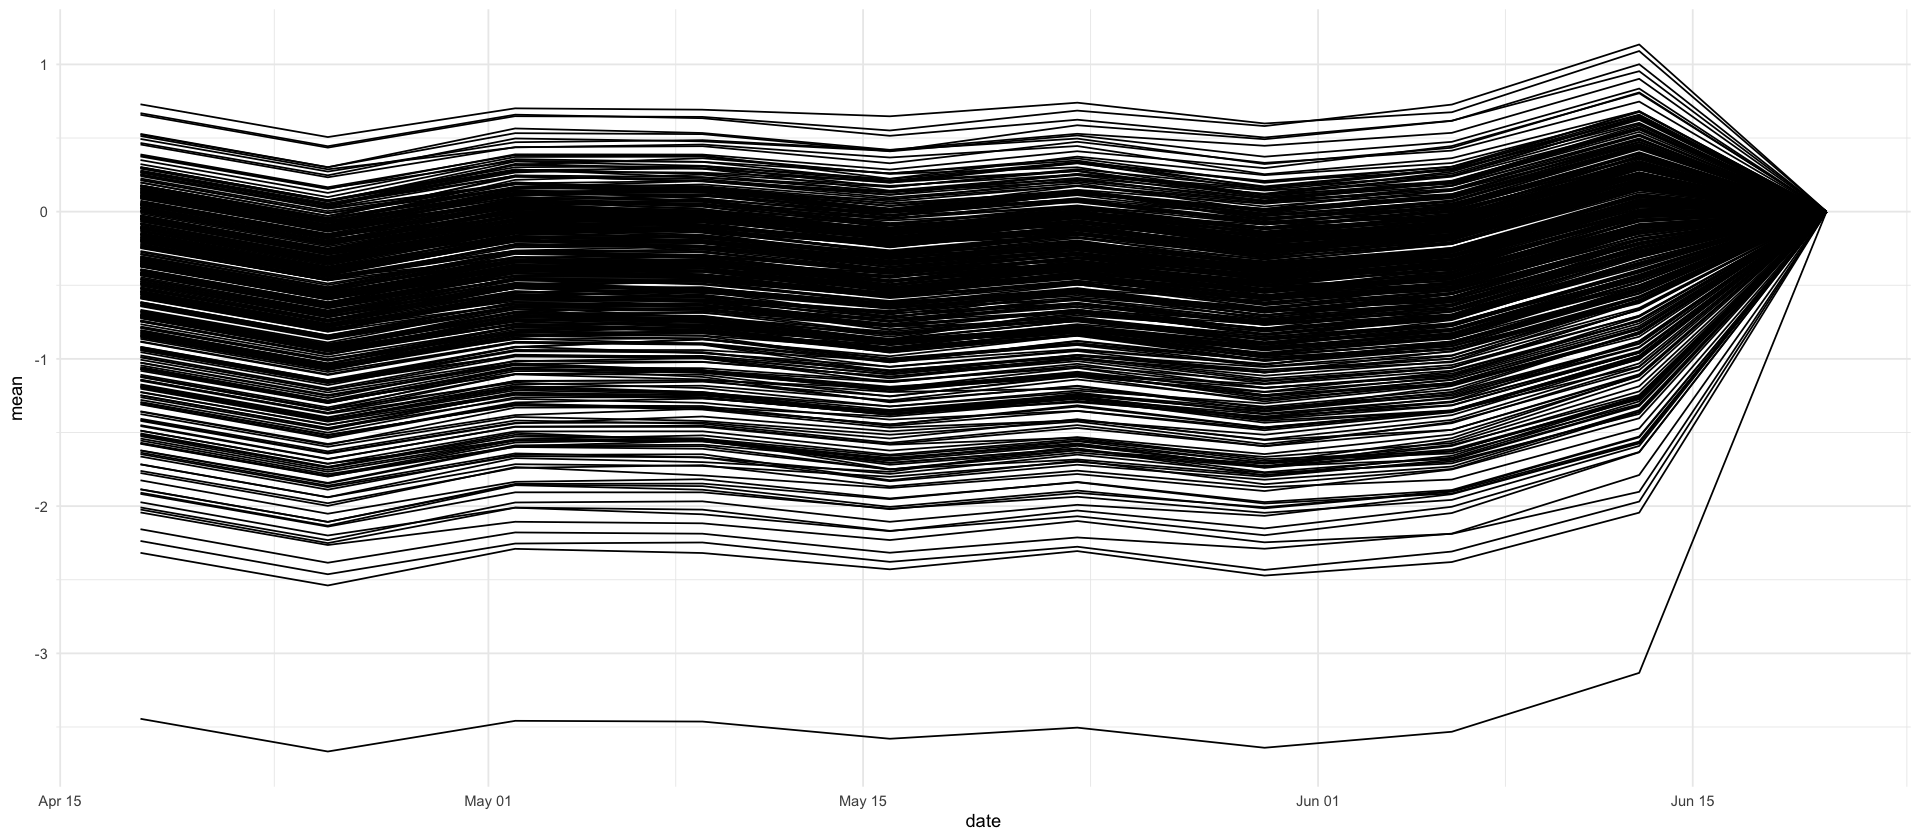

In [3]:
showcase_results <- read_csv(here("data/results/4_local_outbreak_model/showcase.csv"))
showcase_results %>%
    filter(str_starts(variable, "log_rho_")) %>%
    ggplot(aes(date, mean, group=c)) +
    geom_line()

In [4]:
toennis_results <- py_load_object(
    here("data/results/4_local_outbreak_model/results.pickle")
)

theta <- toennis_results[[1]]
predictions <- toennis_results[[3]]
dates <- toennis_results[[4]]
y <- toennis_results[[5]]

Warning message in poetry_config(required_module):
"This project appears to use Poetry for Python dependency management.
However, the 'poetry' command line tool is not available.
reticulate will be unable to activate this project.
Please ensure that 'poetry' is available on the PATH."


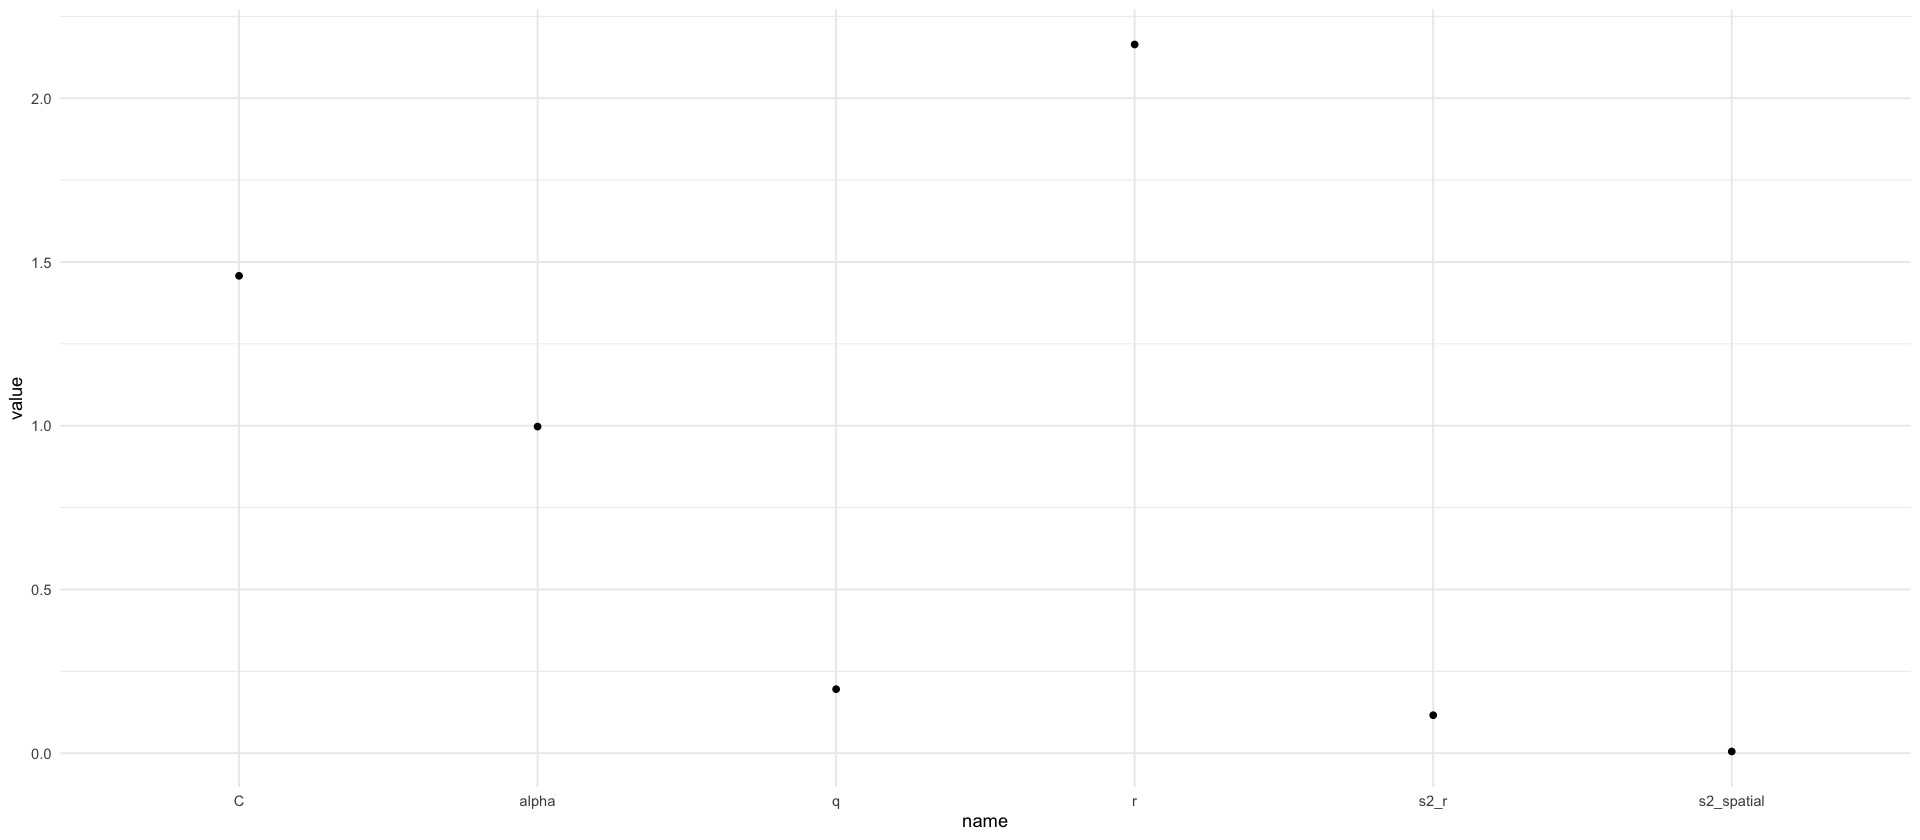

In [5]:
theta_to_params(theta) %>%
    enframe() %>%
    ggplot(aes(name, value)) +
    geom_point()


In [6]:
np <- import("numpy")
means <- np$array(predictions[[1]])
sds <- np$array(predictions[[2]])
quantiles <- np$array(predictions[[3]])

dim(quantiles)


[1]   23 4401

In [7]:
# convert this python array percentiles_of_interest = jnp.array(
#    [0.01, 0.025, *(0.05 * jnp.arange(1, 20)), 0.975, 0.99]
#)
rownames(quantiles) <- c(
    "1%", "2.5%", "5%", "10%", "15%", "20%",
    "25%", "30%",  "35%", "40%",
    "45%", "50%",  "55%", "60%",
    "65%", "70%",  "75%", "80%",
    "85%", "90%",  "95%", "97.5%", "99%"
)
df <- as_tibble(cbind(means, sds, t(quantiles)), .name_repair = "minimal") %>%
    mutate(variable = c("y_total", paste0("y_total_", 1:400), paste0("log_rho_", outer(1:400, 1:10, FUN = function(x, y) paste0(x, "_", y))
)))

means,sds,1%,2.5%,5%,10%,15%,20%,25%,30%,⋯,75%,80%,85%,90%,95%,97.5%,99%,variable,c,t
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
-1.0250969,0.2194198,-1.606966,-1.468712,-1.346025,-1.135762,-1.0788842,-1.0788516,-1.0788188,-1.0787860,⋯,-1.0535270,-0.9555636,-0.8394666,-0.7482306,-0.5353260,-0.4220565,-0.3270586,log_rho_1_1,1,1
-0.9242847,0.2275634,-1.260602,-1.152827,-1.049064,-1.036535,-1.0364950,-1.0364547,-1.0364144,-1.0363741,⋯,-0.8875565,-0.7842902,-0.6903921,-0.5268161,-0.3976837,-0.2824717,-0.1877591,log_rho_2_1,2,1
-1.5144948,0.2207027,-2.162001,-2.004124,-1.923558,-1.735724,-1.6016507,-1.5293446,-1.5292366,-1.5291284,⋯,-1.5284489,-1.5046592,-1.3834943,-1.2654990,-1.0671871,-0.9784223,-0.8452144,log_rho_3_1,3,1
-0.6137719,0.2487997,-1.433291,-1.319668,-1.160541,-1.005842,-0.9038914,-0.8029464,-0.7024443,-0.5483716,⋯,-0.4822153,-0.4821872,-0.4821591,-0.4821310,-0.4821028,-0.3815038,-0.2668484,log_rho_4_1,4,1
-1.0805322,0.3426629,-1.406175,-1.302271,-1.302251,-1.302213,-1.3021740,-1.3021351,-1.3020964,-1.3020576,⋯,-0.8615669,-0.7476543,-0.6356784,-0.4783570,-0.3408009,-0.2616650,-0.1316368,log_rho_5_1,5,1
-0.7105849,0.2324953,-1.468378,-1.349820,-1.237353,-1.101016,-0.9642230,-0.8555118,-0.7570854,-0.6254431,⋯,-0.6030866,-0.6030854,-0.6030842,-0.6030830,-0.5482785,-0.3595549,-0.3224477,log_rho_6_1,6,1


Warning message:
"Removed 400 rows containing missing values or values outside the scale range
(`geom_line()`)."


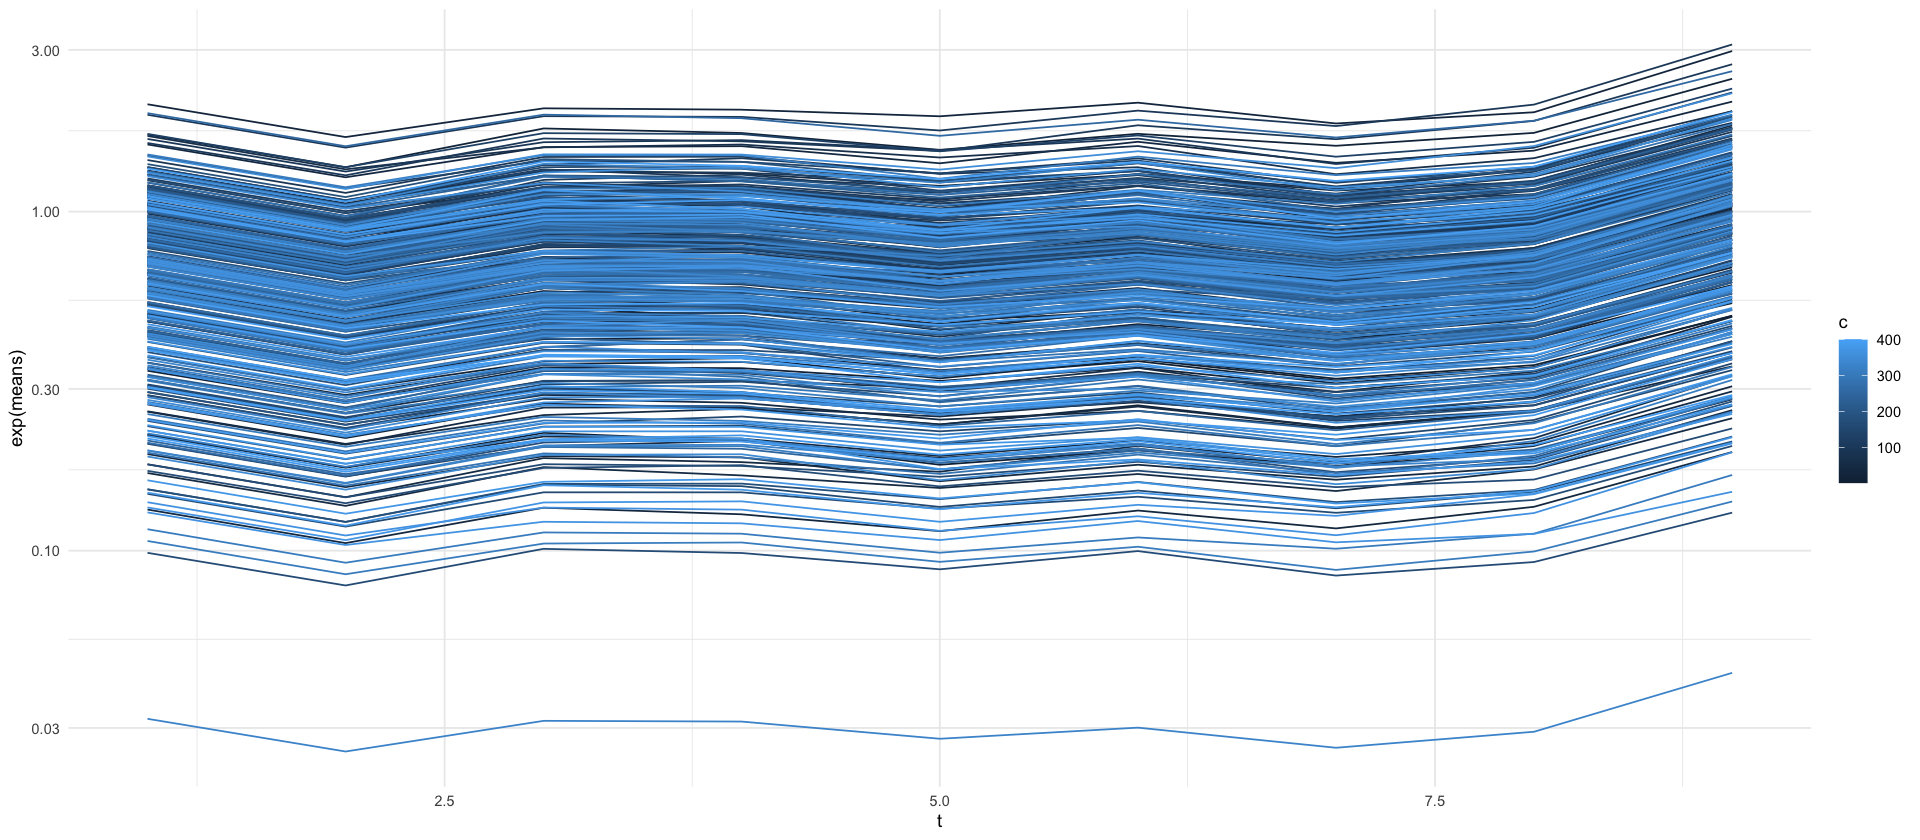

In [8]:
log_rhos <- df %>%
    filter(str_starts(variable, "log_rho_")) %>%
    # extract both indices from variable names like log_rho_2_1
    mutate(c = as.numeric(str_extract(variable, "log_rho_(\\d+)_(\\d+)", group=1))) %>%
    mutate(t = as.numeric(str_extract(variable, "log_rho_(\\d+)_(\\d+)", group=2))) 
log_rhos %>%
    head()

log_rhos %>%
    ggplot(aes(t, exp(means), color=c, group=c)) +
    geom_line() +
    xlim(NA, 9) +
    scale_y_log10()

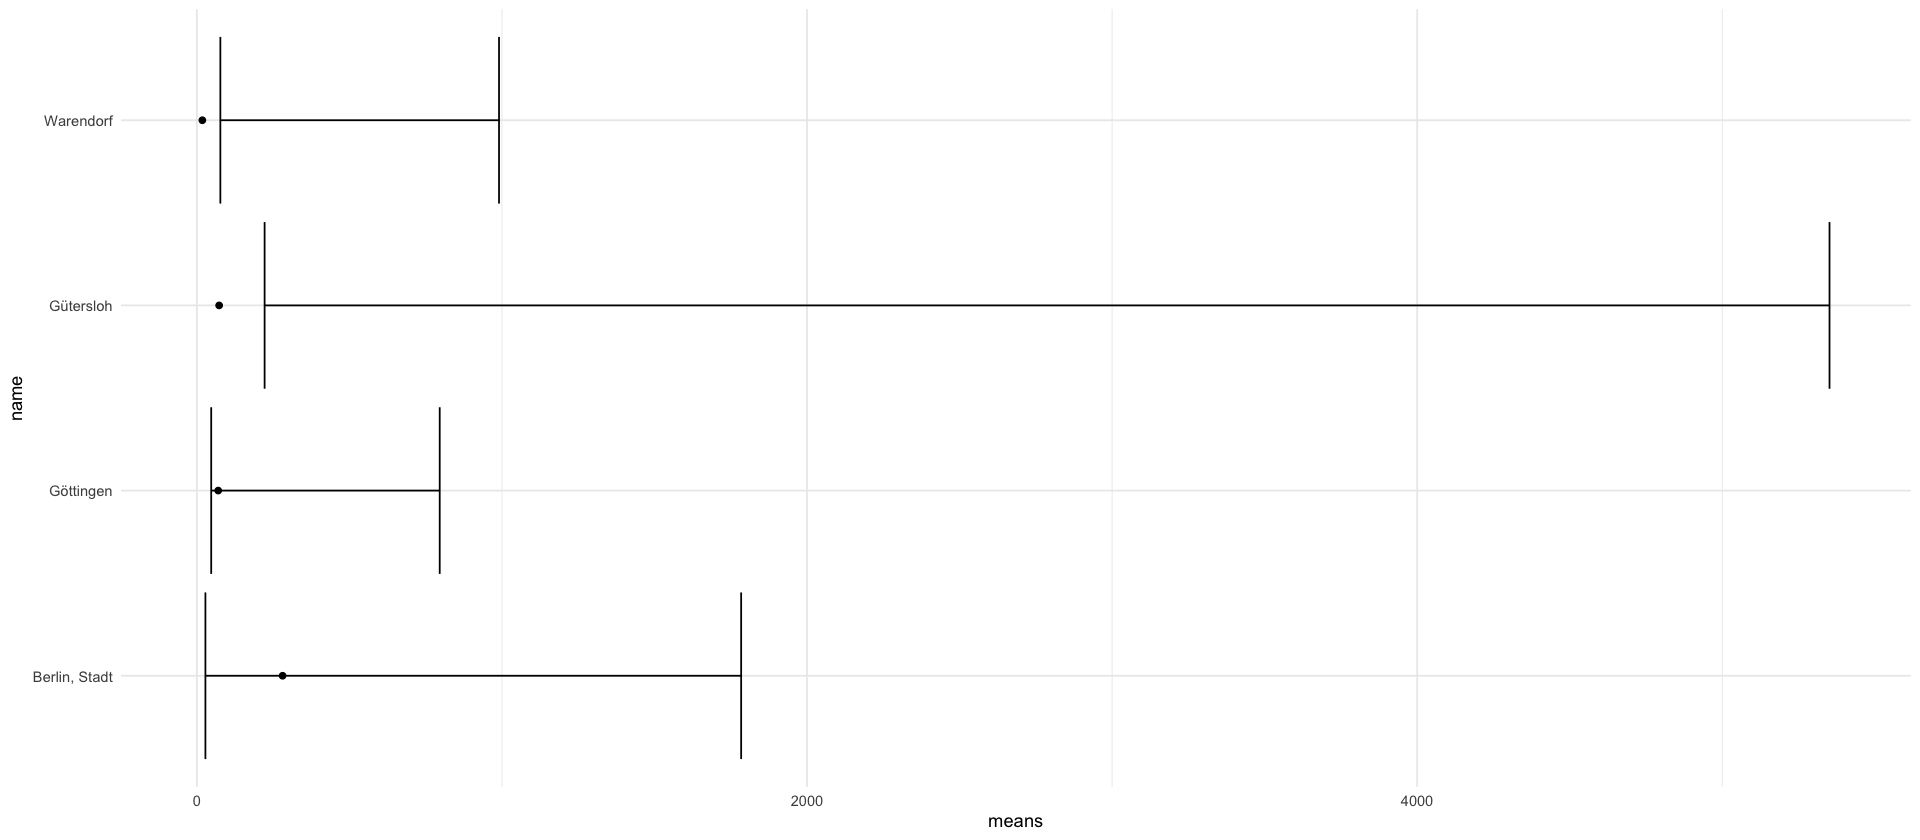

In [9]:
df %>%
    filter(str_starts(variable, "y_total_")) %>%
    mutate(c = as.numeric(str_extract(variable, "y_total_(\\d+)", group=1))) %>%
    inner_join(ags_county_dict, by = "c") %>%
    inner_join(filter(full_truth_county, date == '2020-06-13'), by=c("ags")) %>%
    filter(means >= 100) %>%
    arrange(desc(means)) %>%
    ggplot(aes(y = name, x = means)) +
    geom_errorbarh(aes(xmin = `2.5%`, xmax = `97.5%`)) +
    geom_point(aes(x = cases))

# Comparison to ECDC forecasts

In [10]:
forecasts_directory <- here("data/results/4_local_outbreak_model")

df_forecasts <- list.files(forecasts_directory, pattern="forecasts_.*.csv", full.names = TRUE)  %>%
    # infer the forecast date from the filename - have to add 10 weeks to the date in the filename as it is the initial date
    lapply(function(file) read_csv(file) %>% mutate(date = ymd(str_extract(string = file, pattern = "\\d{4}-\\d{2}-\\d{2}")) + days(10 * 7))) %>% 
    bind_rows(.)

In [11]:
df_baseline <- read_csv(here("data/processed/ECDC_FCH_EuroCOVIDhub-baseline.csv")) %>%
    filter(date <= max(df_forecasts$date))

df_itww <- read_csv(here("data/processed/ECDC_FCH_ITWW-county_repro.csv")) %>%
    filter(date <= max(df_forecasts$date))

df_ensemble <- read_csv(here("data/processed/ECDC_FCH_EuroCOVIDhub-ensemble.csv")) %>%
    filter(date <= max(df_forecasts$date))


In [12]:
all_df <- rbind(
    df_forecasts %>% filter(variable == 'y_total') %>% select(df_baseline %>% names) %>% mutate(model='ssm'),
    df_baseline %>% mutate(model='baseline'),
    df_itww %>% mutate(model='itww'),
    df_ensemble %>% mutate(model='ensemble')
)

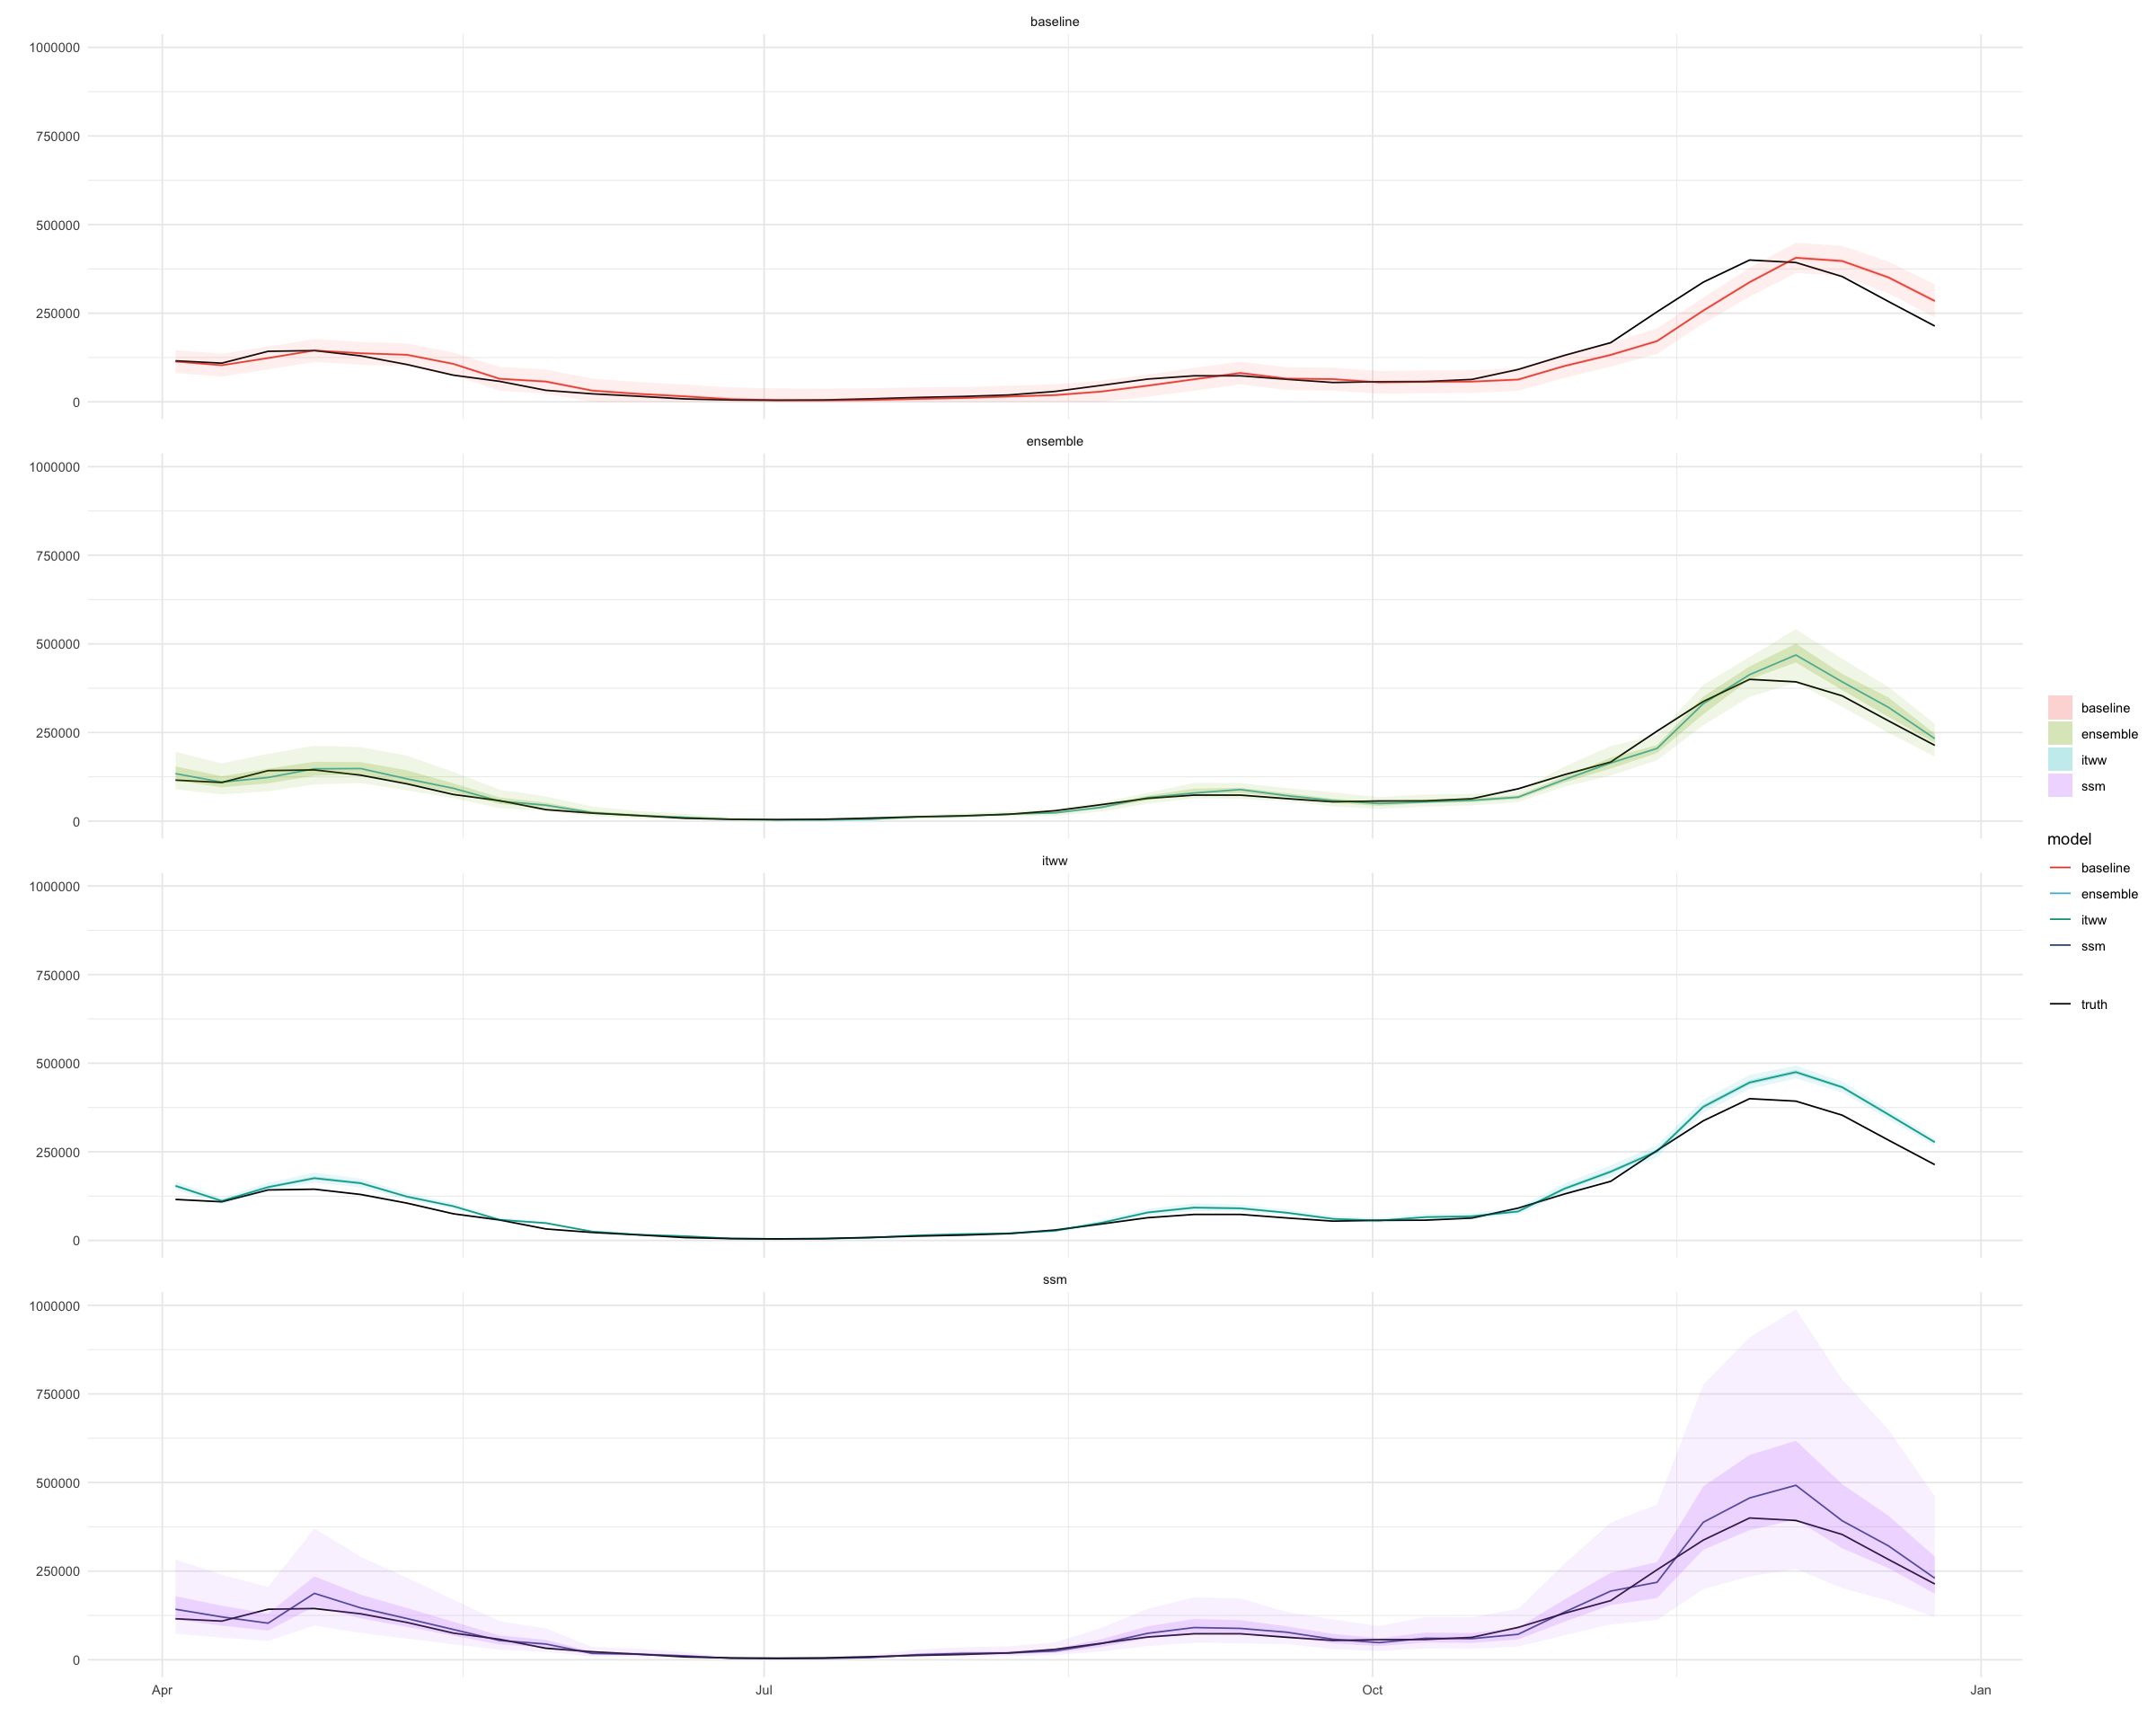

In [13]:
# larger figures
options(
    repr.plot.width=20,
    repr.plot.height=16
)
ggplot(all_df, aes(date)) +
    geom_line(aes(y=`50.0 %`, color=model)) +
    geom_line(aes(x = date, y = cases, linetype = "truth"), data = filter(full_truth, date <= max(all_df$date), date >= min(all_df$date))) +
    geom_ribbon(aes(ymin = `25.0 %`, ymax = `75.0 %`, fill = model), alpha = 0.2) +
    geom_ribbon(aes(ymin = `2.5 %`, ymax = `97.5 %`, fill = model), alpha = 0.1) +
    labs(x = "", y = "", linetype = NULL, fill = NULL) +
    #scale_x_date(breaks = "1 months", date_labels = "%b %y", expand = expansion(mult = c(0.01, 0.01))) + 
    facet_wrap(~model, ncol = 1) 
#    coord_cartesian(ylim=c(NA, 1.5e5))
    #scale_y_log10()

In [14]:
quantiles <- c(0.01, 0.025, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3, 0.35, 0.45, 0.5, 0.55, 0.6, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.975, 0.99)
df <- full_truth %>% 
    inner_join(all_df, by="date") %>%
    rename(truth=cases) %>%
    rowwise() %>%
    mutate(
        WIS_decompose = list(WIS_decompose(
            prob=quantiles,
            quant=c(`1.0 %`, `2.5 %`, `5.0 %`, `10.0 %`, `15.0 %`, `20.0 %`, `25.0 %`, `30.0 %`, `35.0 %`, `40.0 %`, `45.0 %`, `50.0 %`, `55.0 %`, `60.0 %`, `65.0 %`, `70.0 %`, `75.0 %`, `80.0 %`, `85.0 %`, `90.0 %`, `95.0 %`, `97.5 %`, `99.0 %`),
            actual= truth
           ))
    ) %>%
    unnest_wider(WIS_decompose) %>%
    group_by(model) %>%
    summarize(
        mae = mean(abs(`50.0 %` - truth), na.rm = TRUE),
        coverage_95 = mean(`2.5 %` <= truth & truth <= `97.5 %`, na.rm = TRUE),
        coverage_50 = mean(`25.0 %` <= truth & truth <= `75.0 %`, na.rm = TRUE),
        WIS = mean(wis),
        sharpness = mean(sharpness),
        underprediction = mean(underprediction),
        overprediction = mean(overprediction),
        mean_error = mean(mean_error),
        length_95 = mean(`97.5 %` - `2.5 %`, na.rm = TRUE),
        length_50 = mean(`75.0 %` - `25.0 %`, na.rm = TRUE),
    ) 

df_table_performance <- df %>%
  mutate(coverage_50 = coverage_50 * 100) %>%
  mutate(coverage_95 = coverage_95 * 100) %>%
  rename(
    `Mean Absolute Error` = mae,
    `Coverage 50% PI [%]` = coverage_50,
    `Coverage 95% PI [%]` = coverage_95,
    `WIS` = WIS,
    `Sharpness` = sharpness,
    `Underprediction` = underprediction,
    `Overprediction` = overprediction,
  ) %>%
  select(-length_95, -length_50, -mean_error) %>%
  t() %>%  # Transpose
  as.data.frame() %>%  # Convert to data frame
  rownames_to_column(var = "metric") %>%
  setNames(c("metric", .[1,2:5])) %>%
  slice(-1)

df_table_performance

metric,baseline,ensemble,itww,ssm
<chr>,<chr>,<chr>,<chr>,<chr>
Mean Absolute Error,19664.56,11874.82,18227.64,16878.37
Coverage 95% PI [%],82.05128,94.87179,46.15385,100.00000
Coverage 50% PI [%],25.64103,43.58974,23.07692,74.35897
WIS,13907.185,6877.498,14486.062,9682.098
Sharpness,1462.8722,2742.6090,850.6181,7563.1745
Underprediction,7055.1655,1637.4615,141.1469,597.8727
Overprediction,4493.2704,1973.1142,12686.5361,904.6421


In [15]:
df_table_relative_performance <- df_table_performance %>%
    mutate(across(baseline:ssm, as.numeric)) %>%
    # relative to baseline, first column
    mutate(across(ensemble:ssm, ~ .x / baseline)) %>%
    select(-baseline)

df_table_relative_performance 

metric,ensemble,itww,ssm
<chr>,<dbl>,<dbl>,<dbl>
Mean Absolute Error,0.6038691,0.92692844,0.85831414
Coverage 95% PI [%],1.1562500,0.56250006,1.21875003
Coverage 50% PI [%],1.6999996,0.89999973,2.89999934
WIS,0.4945284,1.04162431,0.69619395
Sharpness,1.8748111,0.58147123,5.17008560
Underprediction,0.2320940,0.02000618,0.08474255
Overprediction,0.4391265,2.82345262,0.20133266


In [30]:
full_truth %>% 
    inner_join(all_df, by="date") %>%
    rename(truth=cases) %>%
    rowwise() %>%
    mutate(
        WIS_decompose = list(WIS_decompose(
            prob=quantiles,
            quant=c(`1.0 %`, `2.5 %`, `5.0 %`, `10.0 %`, `15.0 %`, `20.0 %`, `25.0 %`, `30.0 %`, `35.0 %`, `40.0 %`, `45.0 %`, `50.0 %`, `55.0 %`, `60.0 %`, `65.0 %`, `70.0 %`, `75.0 %`, `80.0 %`, `85.0 %`, `90.0 %`, `95.0 %`, `97.5 %`, `99.0 %`),
            actual= truth
           ))
    ) %>%
    unnest_wider(WIS_decompose) %>%
    select(date, model, wis) %>%
    pivot_wider(
        names_from = model,
        values_from = wis
    ) %>%
    mutate(across(ssm:ensemble, ~ .x / baseline))  %>%
    select(-baseline) %>%
    pivot_longer(
        cols = ssm:ensemble,
        names_to = "model",
        values_to = "relative_wis"
    ) %>%
    group_by(model) %>%
    summarize(
        rel_wis_smaller_1 = mean(relative_wis < 1),
        mean_rel_wis = exp(mean(log(relative_wis), na.rm = TRUE))
    )


model,rel_wis_smaller_1,mean_rel_wis
<chr>,<dbl>,<dbl>
ensemble,0.7692308,0.5708629
itww,0.7179487,0.6623655
ssm,0.6666667,0.8218096
